# Импорты

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
way = "/content/drive/MyDrive/Colab_Notebooks/aaa_ml/datasets/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import missingno as msno
import re
import xgboost as xgb
import optuna

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import median_absolute_error

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression

from gensim.models.fasttext import FastText
from gensim.models.word2vec import Word2Vec

from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
from IPython.display import clear_output

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
df = pd.read_csv(way+"train_cars.csv")
df.head()

,id,actual_price,price,start_date,close_date,sale_end_date,brand,model,generation,modification,...,color,year,mileage,owners_count,latitude,longitude,crashes,is_taxi,is_carsharing,description
0,345716,NaN,970000.0,2021-09-13,2021-10-26,NaN,Hyundai,i40,I (2011—2015),2.0 AT (150 л.с.),...,Белый,2014.0,106000,2,57.153033,65.219731,NaN,NaN,NaN,"В отличном состоянии, вложений не требует, нед..."
1,177074,NaN,800000.0,2021-08-29,2021-09-05,NaN,Hyundai,i40,I (2011—2015),2.0 AT (150 л.с.),...,Чёрный,2013.0,179811,> 3,43.262792,46.028635,NaN,NaN,NaN,"Машина хорошом состояни, газ с отметкой, краше..."
2,173452,NaN,580000.0,2021-07-13,2021-07-20,NaN,Hyundai,Solaris,II (2017—2020),1.4 MT (100 л.с.),...,Белый,2018.0,188000,1,43.148800,45.694538,NaN,NaN,NaN,Авто отличном состоянии \nНе Битый Крашено 2 д...
3,87482,NaN,130000.0,2021-10-25,2021-10-26,NaN,Mazda,Demio,DW (1997—2003),1.3 AT (83 л.с.),...,Белый,2002.0,229346,> 3,51.745922,107.471918,NaN,NaN,NaN,Срочная продажа! Правый порог под замену ( сгн...
4,103633,NaN,180000.0,2021-08-19,2021-08-23,NaN,Mazda,Demio,DW (1997—2003),1.3 AT (83 л.с.),...,Белый,2003.0,202000,> 3,56.963724,60.434034,NaN,NaN,NaN,Для своих годов автомобиль в хорошем состоянии...


In [ ]:
df_test = pd.read_csv(way+"val_cars.csv")
df_test.head()

,id,sale_end_date,brand,model,generation,modification,equipment,body_type,color,year,mileage,owners_count,latitude,longitude,crashes,is_taxi,is_carsharing,description
0,436662,2022-07-24,Kia,Ceed,ED (2006—2010),1.6 MT (122 л.с.),Люкс,Хетчбэк,Серебряный,2009.0,140000,2,57.153033,64.803854,0.0,0.0,0.0,Жаркая пора в КЛЮЧАВТО!\n\nПродаём автомобили ...
1,427226,2022-07-21,Nissan,Qashqai,II рестайлинг (2017—н. в.),1.2 DIG-T CVT (115 л.с.),SE,Внедорожник,Белый,2018.0,37597,1,55.798551,48.820695,0.0,0.0,0.0,Купим дорого Ваш автомобиль в день обращения.\...
2,153261,2022-07-24,Skoda,Kodiaq,I (2016—н. в.),2.0 TSI 4x4 DSG (180 л.с.),NaN,Внедорожник,Чёрный,2021.0,38400,1,55.755814,37.947757,0.0,0.0,0.0,⚡ 23 и 24 июля Weekend продаж автомобилей с пр...
3,411283,2022-07-13,Mercedes-Benz,GLC-класс,X253 (2015—2019),GLC 250 2.0 4MATIC 9G-Tronic (211 л.с.),NaN,Внедорожник,Синий,2017.0,39004,1,55.755814,37.338862,0.0,0.0,0.0,"🌚🔥Ночь продаж в РОЛЬФ Ясенево, только 14.07, у..."
4,248112,2022-07-13,Kia,Cerato,III рестайлинг (2016—2020),1.6 AT (130 л.с.),NaN,Седан,Серый,2017.0,63150,1,59.939095,30.003614,1.0,0.0,0.0,Успейте забрать с максимальной выгодой!\n\nАвт...


In [ ]:
print(df.shape)
print(df_test.shape)

(478287, 22)
(1611, 18)


# Разведка

In [ ]:
np.abs(df['actual_price'] - df['price']).median()

29000.0

In [ ]:
df['actual_price'].dropna().shape

(15367,)

In [ ]:
np.abs(df['is_taxi'] - df['is_carsharing']).median()

0.0

In [ ]:
df['owners_count'].unique()

array(['2', '> 3', '1', '3'], dtype=object)

In [ ]:
df_actual = df[df['actual_price'].notna()].drop(['start_date', 'close_date', 'is_carsharing', 'price', 'id'], axis=1)
df_test_fixed = df_test.drop(['is_carsharing', 'id'], axis=1)
df_actual.shape

(15367, 17)

<Axes: >

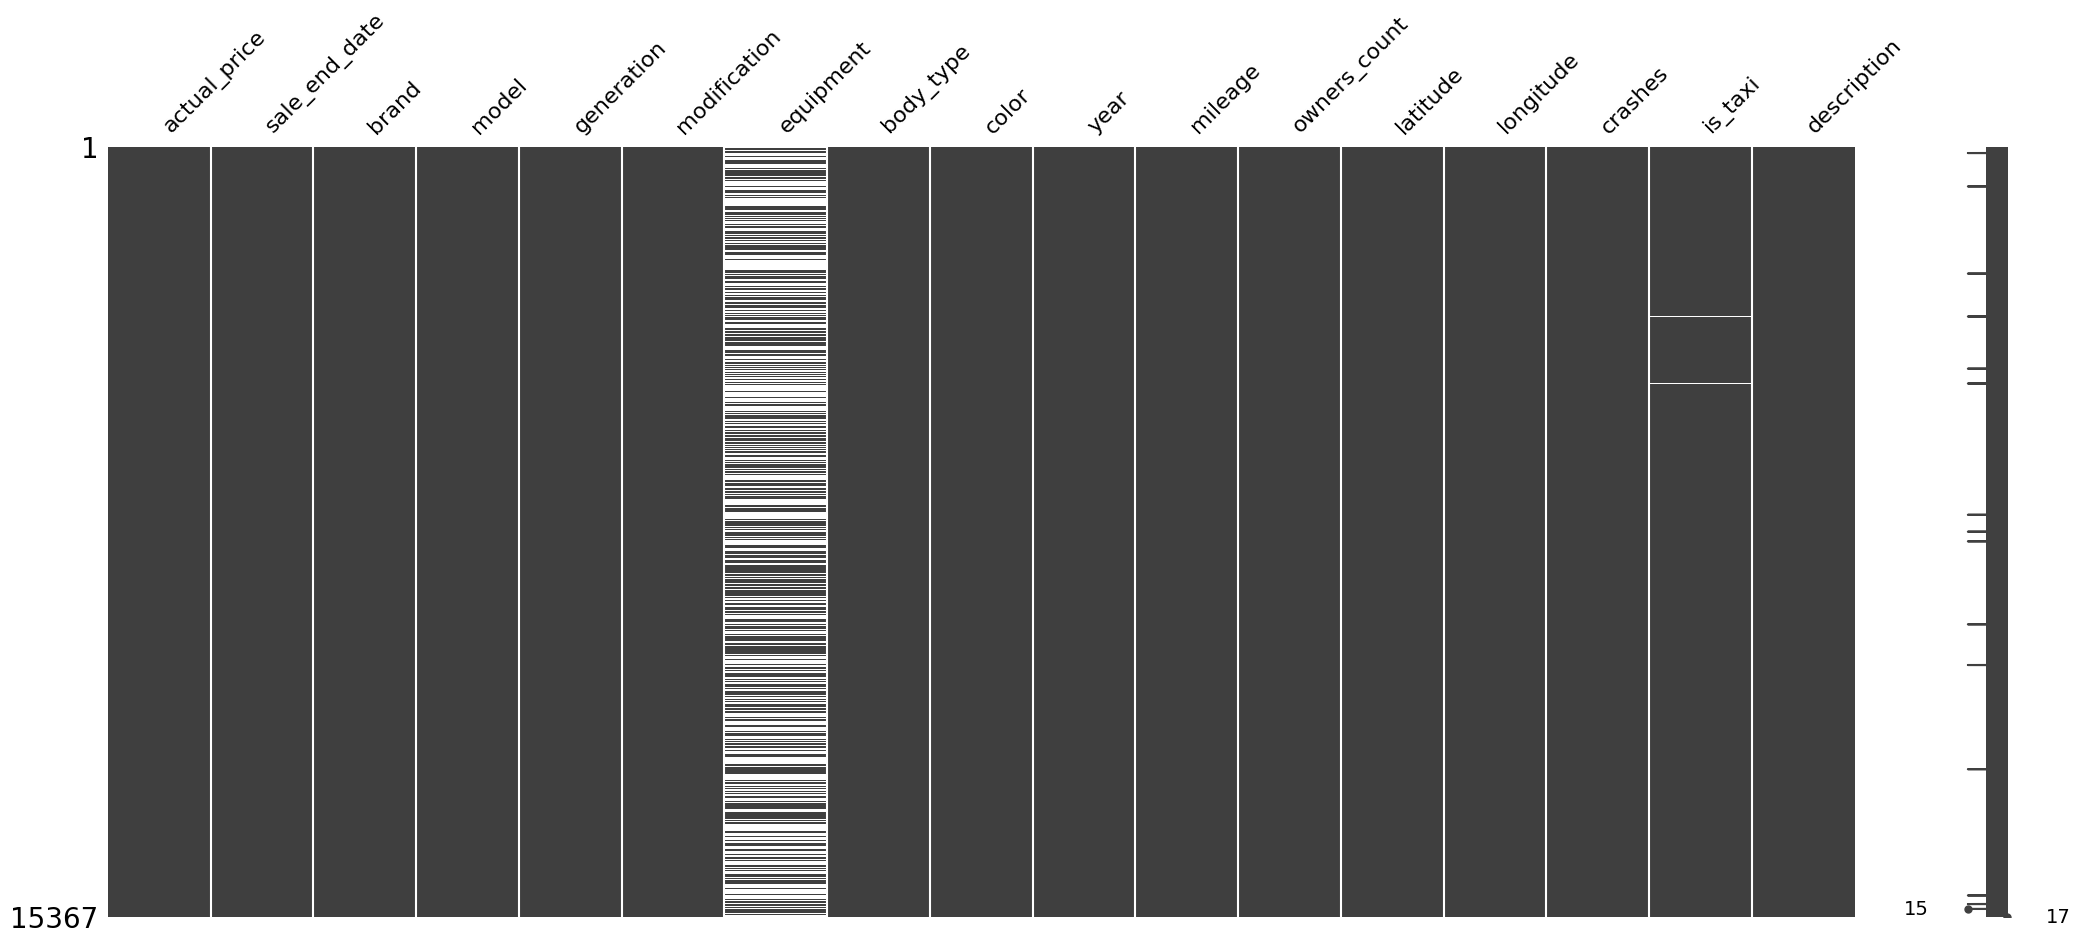

In [ ]:
msno.matrix(df_actual)

In [ ]:
for_fillna = {'equipment': '0', 'is_taxi': 0.0}

def df_filling(df_for_fill):
  df_for_fill = df_for_fill.fillna(for_fillna)
  df_for_fill.loc[df_for_fill['owners_count'] == '> 3', 'owners_count'] = 4
  df_for_fill['owners_count'] = df_for_fill['owners_count'].astype(int)

  return df_for_fill

df_actual = df_filling(df_actual)
df_test_fixed = df_filling(df_test_fixed)

In [ ]:
df_test_fixed

,sale_end_date,brand,model,generation,modification,equipment,body_type,color,year,mileage,owners_count,latitude,longitude,crashes,is_taxi,description
0,2022-07-24,Kia,Ceed,ED (2006—2010),1.6 MT (122 л.с.),Люкс,Хетчбэк,Серебряный,2009.0,140000,2,57.153033,64.803854,0.0,0.0,Жаркая пора в КЛЮЧАВТО!\n\nПродаём автомобили ...
1,2022-07-21,Nissan,Qashqai,II рестайлинг (2017—н. в.),1.2 DIG-T CVT (115 л.с.),SE,Внедорожник,Белый,2018.0,37597,1,55.798551,48.820695,0.0,0.0,Купим дорого Ваш автомобиль в день обращения.\...
2,2022-07-24,Skoda,Kodiaq,I (2016—н. в.),2.0 TSI 4x4 DSG (180 л.с.),0,Внедорожник,Чёрный,2021.0,38400,1,55.755814,37.947757,0.0,0.0,⚡ 23 и 24 июля Weekend продаж автомобилей с пр...
3,2022-07-13,Mercedes-Benz,GLC-класс,X253 (2015—2019),GLC 250 2.0 4MATIC 9G-Tronic (211 л.с.),0,Внедорожник,Синий,2017.0,39004,1,55.755814,37.338862,0.0,0.0,"🌚🔥Ночь продаж в РОЛЬФ Ясенево, только 14.07, у..."
4,2022-07-13,Kia,Cerato,III рестайлинг (2016—2020),1.6 AT (130 л.с.),0,Седан,Серый,2017.0,63150,1,59.939095,30.003614,1.0,0.0,Успейте забрать с максимальной выгодой!\n\nАвт...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1606,2022-07-30,Kia,Sportage,IV рестайлинг (2018—н. в.),2.0 MPI 4WD AT (150 л.с.),0,Внедорожник,Красный,2019.0,44500,1,55.755814,37.122272,0.0,0.0,"🚗НЕ ЖДИТЕ ПОКА КУПЯТ ВАШ АВТО, В РОЛЬФ ЗВЕЗДА ..."
1607,2022-07-26,ВАЗ (LADA),XRAY,I (2015—н. в.),1.8 AMT (122 л.с.),Exclusive,Хетчбэк,Серый,2018.0,83449,1,55.755814,37.305372,0.0,0.0,"АСЦ / ЧЕСТНО, Автомобили с пробегом.\nМы готов..."
1608,2022-07-11,Toyota,RAV4,IV рестайлинг (2015—2019),2.0 CVT (146 л.с.),Comfort,Внедорожник,Чёрный,2018.0,57217,1,59.939095,30.588931,1.0,0.0,На данном сайте представлены НЕ ВСЕ автомобили...
1609,2022-07-27,BMW,X5,G05 (2018—н. в.),30d 3.0 xDrive Steptronic (249 л.с.),M Sport Pro,Внедорожник,Чёрный,2021.0,14900,1,55.755814,38.126297,0.0,0.0,Выкупим Ваш 🚗 в день обращения – до 💯% от рыно...


In [ ]:
df.nunique()

id               478287
actual_price       4695
price             18389
start_date          259
close_date          259
sale_end_date       181
brand                65
model               553
generation          851
modification       1116
equipment           783
body_type            11
color                17
year                 70
mileage           99633
owners_count          4
latitude           3372
longitude        478287
crashes              13
is_taxi               2
is_carsharing         2
description      447804
dtype: int64

Кандидаты на лейбл энкодинг: brand, body_type, color, year
id -

actual price - таргет

price - цифра

sale_end_date

brand - one hot

eqipment + generation - start year + modification - horsepower - векторизация?

generation start year - сплит

modification horsepower - число

body_type - one hot

color - one hot

year - label enc

milleage, owners count, latitude, longtitude - цифры

is_taxi - цифра

description - текст

model - average

In [ ]:
df_actual['equipment'].value_counts()[:50]

0                 7920
Базовая           1138
Comfort            554
Luxe               333
Base               313
Prestige           224
Style              211
Active             160
Elegance           158
SE                 145
Sport              132
Classic            126
Cosmo              126
M Sport            118
Instyle            108
Ambition            90
Supreme             86
Drive               78
Enjoy               78
Titanium            77
Luxury              72
Business            72
Privilege           68
Intense             67
Life                64
Luxe 60Th           64
Trend               63
Особая Серия        62
Особая серия        59
Premium             59
SE+                 58
Hockey Edition      58
Comfort Plus        55
Comfortline         53
Travel              49
Highline            48
M Sport Pro         48
Trendline           47
Invite              45
Confort             45
Trend Plus          44
Exclusive           42
Executive           41
Trend&Fun  

In [ ]:
year_start_pattern = r"\((\d{4})—"
year_fin_pattern = r"—(\d{4})\)"
hp_pattern = r"(\d+)\s*л\.с"

def extract_start_year(generation_st):
    match = re.search(year_start_pattern, generation_st)
    return int(match.group(1)) if match else -1

def extract_fin_year(generation_st):
    match = re.search(year_fin_pattern, generation_st)
    return int(match.group(1)) if match else 2023

def extract_hp(modification_st):
    match = re.search(hp_pattern, modification_st)
    return int(match.group(1)) if match else -1

In [ ]:
df['generation'].apply(extract_fin_year).value_counts()

2023    40974
2015    40202
2010    34747
2014    33902
2013    33263
2012    32502
2011    28136
2018    23680
2016    23363
2017    23321
2009    21395
2008    21032
2020    17952
2019    16196
2006    12953
2007    11796
2003    10022
2005     8777
2021     7725
2004     5300
2000     5264
2022     4235
1999     2981
2001     2899
1996     2674
1997     2475
2002     2032
1988     1842
1998     1615
1994     1469
1984      702
1995      536
1992      527
1970      462
1972      428
1991      305
1993      284
1985      283
1989       21
1990        8
1986        7
Name: generation, dtype: int64

In [ ]:
df['modification'].apply(extract_hp).value_counts().get(-1, 0)

0

In [ ]:
equipment_counts = df_actual['equipment'].value_counts()

def equipment_fix(equip, threshold=6):
    if pd.isna(equip) or equipment_counts.get(equip, 0) < threshold:
        return '0'
    else:
        return equip

In [ ]:
df_eqip = df['equipment'].apply(equipment_fix)


df_actual['equipment'] = df_actual['equipment'].apply(equipment_fix)
df_test_fixed['equipment'] = df_test_fixed['equipment'].apply(equipment_fix)

In [ ]:
label_eq = LabelEncoder()
label_eq.fit(df_eqip)


df_actual['equipment_encoded'] = label_eq.transform(df_actual['equipment'])
df_test_fixed['equipment_encoded'] = label_eq.transform(df_test_fixed['equipment'])

In [ ]:
df_actual['equipment_encoded'].value_counts()

0      8347
128    1138
17      554
65      333
10      313
       ... 
60        6
99        6
95        6
31        6
110       6
Name: equipment_encoded, Length: 138, dtype: int64

In [ ]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')

for_one_hots = ['body_type', 'color', 'brand']

one_hot_cols = encoder.fit(df[for_one_hots])

def reorganisation(df_reorg):
  new_df = pd.DataFrame({
        'start_year': df_reorg['generation'].apply(extract_start_year),
        'fin_year': df_reorg['generation'].apply(extract_fin_year),
        'horses': df_reorg['modification'].apply(extract_hp)
    })

  dummies = one_hot_cols.transform(df_reorg[for_one_hots])
  encoded_df = pd.DataFrame(dummies, columns=encoder.get_feature_names_out(for_one_hots), index=df_reorg.index)

  return new_df.join(encoded_df)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
fixed_columns = ['body_type', 'color', 'brand']

train = df_actual.copy().drop(fixed_columns, axis = 1)
train = train.join(reorganisation(df_actual))

test = df_test_fixed.copy().drop(fixed_columns, axis = 1)
test = test.join(reorganisation(df_test_fixed))

In [ ]:
my_fc_bodytest = reorganisation(df_actual)

df_actual[my_fc_bodytest['body_type_Внедорожник'] == 1]['body_type'].unique()

array(['Внедорожник'], dtype=object)

In [ ]:
train.head()

,actual_price,sale_end_date,model,generation,modification,equipment,year,mileage,owners_count,latitude,...,brand_ZOTYE,brand_Богдан,brand_ВАЗ (LADA),brand_ВИС,brand_ГАЗ,brand_ЗАЗ,brand_ИЖ,brand_Москвич,brand_ТагАЗ,brand_УАЗ
198,499000.0,2022-06-24,Kalina,II (2013—2018),1.6 AT (98 л.с.),0,2014.0,105070,1,59.939095,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
208,815000.0,2022-04-05,Solaris,II (2017—2020),1.4 MT (100 л.с.),0,2017.0,65000,1,56.852593,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
234,505000.0,2022-04-20,Passat,B6 (2005—2010),2.0 TDI DSG (140 л.с.),0,2009.0,247657,4,45.035566,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
244,885000.0,2022-06-15,Sandero Stepway,II рестайлинг (2018—н. в.),1.6 MT (82 л.с.),0,2019.0,18748,1,59.939095,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
245,793500.0,2022-04-05,Sandero Stepway,II рестайлинг (2018—н. в.),1.6 MT (82 л.с.),Life,2019.0,32668,1,55.441606,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
test.head()

,sale_end_date,model,generation,modification,equipment,year,mileage,owners_count,latitude,longitude,...,brand_ZOTYE,brand_Богдан,brand_ВАЗ (LADA),brand_ВИС,brand_ГАЗ,brand_ЗАЗ,brand_ИЖ,brand_Москвич,brand_ТагАЗ,brand_УАЗ
0,2022-07-24,Ceed,ED (2006—2010),1.6 MT (122 л.с.),Люкс,2009.0,140000,2,57.153033,64.803854,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2022-07-21,Qashqai,II рестайлинг (2017—н. в.),1.2 DIG-T CVT (115 л.с.),SE,2018.0,37597,1,55.798551,48.820695,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2022-07-24,Kodiaq,I (2016—н. в.),2.0 TSI 4x4 DSG (180 л.с.),0,2021.0,38400,1,55.755814,37.947757,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2022-07-13,GLC-класс,X253 (2015—2019),GLC 250 2.0 4MATIC 9G-Tronic (211 л.с.),0,2017.0,39004,1,55.755814,37.338862,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2022-07-13,Cerato,III рестайлинг (2016—2020),1.6 AT (130 л.с.),0,2017.0,63150,1,59.939095,30.003614,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Модель машины

In [ ]:
df['model'].value_counts().describe()

count      553.000000
mean       864.895118
std       1407.033835
min          3.000000
25%         70.000000
50%        287.000000
75%       1016.000000
max      10088.000000
Name: model, dtype: float64

In [ ]:
df.groupby('model').agg({'brand': 'nunique'})['brand'].value_counts()

1    546
2      7
Name: brand, dtype: int64

## Вариант со средним

In [ ]:
model_average = df.groupby('model').agg({'price': 'mean'})
model_average.head(3)

,price
model,
1 серия,666365.294363
100,122496.808628
107,274727.524752


In [ ]:
train['model_avg'] = train['model'].apply(lambda x: round(model_average.loc[x]))
test['model_avg'] = test['model'].apply(lambda x: round(model_average.loc[x]))
train['model_avg']

198        417662.0
208        761776.0
234        338327.0
244        783375.0
245        783375.0
            ...    
478217    2293349.0
478218     926784.0
478241     592846.0
478256     483770.0
478270     394043.0
Name: model_avg, Length: 15367, dtype: float64

# Описание машины

## Ворд2век

In [ ]:
description = df['description']
description_train = train['description']
description_test = test['description']
description

0         В отличном состоянии, вложений не требует, нед...
1         Машина хорошом состояни, газ с отметкой, краше...
2         Авто отличном состоянии \nНе Битый Крашено 2 д...
3         Срочная продажа! Правый порог под замену ( сгн...
4         Для своих годов автомобиль в хорошем состоянии...
                                ...                        
478282    16&#34; стальные колесные диски\nABS\nБелый\nИ...
478283    В хорошем состоянии, есть косяки по кузову на ...
478284    КАСКО каждому при покупке в КРЕДИТ🔥🔥🔥\nМы купи...
478285    Состояние нового авто, в родной краске, хороша...
478286    Состояние новой машины, без каких либо вложени...
Name: description, Length: 478287, dtype: object

In [ ]:
WORD_PATTERN = '(?u)\\b\\w\\w+\\b'
reg_exp = re.compile(pattern=WORD_PATTERN)

In [ ]:
sentences = [reg_exp.findall(s.lower()) for s in description]
sentences_train = [reg_exp.findall(s.lower()) for s in description_train]
sentences_test = [reg_exp.findall(s.lower()) for s in description_test]
sentences[:1]

[['отличном',
  'состоянии',
  'вложений',
  'не',
  'требует',
  'недавно',
  'пройдены',
  'то',
  'диагностика',
  'автокорейце',
  'замечаний',
  'нет',
  'подтверждающие',
  'документы',
  'наличии',
  'машина',
  'богатой',
  'комплектации',
  'кожаный',
  'салон',
  'электросиденья',
  'памятью',
  'обогревами',
  'вентиляцией',
  'климат',
  'контроль',
  'парктроник',
  'два',
  'комплекта',
  'колес',
  'r18',
  'сигнализация',
  'автозапуском',
  'пандора']]

надо потестить параметры

In [ ]:
w2v_model = Word2Vec(vector_size=200, window=6, min_count=1, sg = 1)
w2v_model.build_vocab(sentences)
w2v_model.train(
   corpus_iterable=sentences,
   total_examples=w2v_model.corpus_count,
   epochs=13,
   compute_loss=True,
)

(420932945, 458655834)

In [ ]:
w2v_model.wv.similar_by_word('мерседес')

[('бенц', 0.8599845170974731),
 ('бенс', 0.6050634980201721),
 ('class', 0.6043272614479065),
 ('mercedes', 0.5838770866394043),
 ('benz', 0.5536977052688599),
 ('мл350', 0.5508723258972168),
 ('рус', 0.5507766008377075),
 ('спринтер', 0.5493630170822144),
 ('w211', 0.5486392378807068),
 ('bens', 0.5485128164291382)]

In [ ]:
w2v_model.wv.similar_by_word('новая')

[('свежая', 0.7936028242111206),
 ('резина', 0.752223014831543),
 ('летняя', 0.7398068904876709),
 ('брич', 0.7174093723297119),
 ('езженая', 0.71233069896698),
 ('ходрвая', 0.7081824541091919),
 ('хектора', 0.7029793858528137),
 ('19brig', 0.7020422220230103),
 ('хапилита', 0.7000244855880737),
 ('2сезана', 0.6971871256828308)]

In [ ]:
class Word2VecTransformer:

    def __init__(self, model, word_pattern):

        self.model = model
        self.word_pattern = word_pattern
        self.re = re.compile(pattern=self.word_pattern)

    def fit(self, X):
        return self

    def transform(self, X):

        X_transformed = np.zeros((len(X), self.model.wv.vector_size))
        for i, title in enumerate(X):

            title_vector = np.zeros((self.model.wv.vector_size,))

            if isinstance(title, list):
                tokens = [word.lower() for word in title]
            else:
                tokens = self.re.findall(title.lower())

            if len(tokens) == 0:
              continue

            for token in tokens:
                if token in self.model.wv.key_to_index:
                    title_vector += self.model.wv.get_vector(token)

            X_transformed[i] = title_vector / len(tokens)

        return X_transformed

In [ ]:
w2v_transformer = Word2VecTransformer(model=w2v_model,
                                       word_pattern=WORD_PATTERN)


train_ft = w2v_transformer.transform(sentences_train)
test_ft = w2v_transformer.transform(sentences_test)

In [ ]:
train_ft.shape

(15367, 200)

In [ ]:
train_to_save = pd.DataFrame(train_ft, index=description_train.index)
train_to_save.to_csv('train_word_embedings.csv', header=True)

In [ ]:
test_to_save = pd.DataFrame(test_ft, index=description_test.index)
test_to_save.to_csv('test_word_embedings.csv', header=True)

## Включение эмбедингов

In [ ]:
train_full_embs = pd.read_csv(way + "train_word_embedings.csv").rename({'Unnamed: 0': 'index'}, axis = 1).set_index('index')
train_full_embs.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
index,,,,,,,,,,,,,,,,,,,,,
198,-0.136773,-0.236483,0.184405,0.326522,0.278908,0.117203,-0.075200,0.397017,0.003556,0.093355,...,0.329008,0.011346,-0.127024,0.110104,-0.011347,0.004729,0.055161,-0.218638,-0.152557,-0.196391
208,-0.001353,-0.290293,-0.006887,0.346501,0.352320,-0.024991,0.034144,0.419570,-0.014774,-0.135728,...,0.298078,-0.050627,0.036470,0.091019,0.049190,0.092731,0.100408,-0.259116,-0.068966,-0.181217
234,0.240349,-0.313524,0.137701,0.350781,0.485873,-0.050425,0.127420,0.496703,0.066005,0.150570,...,0.370183,-0.124120,0.013870,-0.102709,-0.031425,0.109712,0.064723,-0.219945,-0.094727,-0.272479
244,0.025599,-0.278879,-0.037872,0.269796,0.286883,-0.023927,0.137897,0.341825,0.051506,-0.098733,...,0.328323,-0.120835,-0.045487,0.031505,-0.017058,0.068061,0.135129,-0.247531,-0.099456,-0.385271
245,-0.108799,-0.206566,0.128026,0.306782,0.235326,0.068452,-0.126011,0.352885,-0.056698,0.008657,...,0.311782,0.039928,-0.203010,0.101849,0.030943,0.049155,-0.007907,-0.200865,-0.156602,-0.241684


In [ ]:
test_embs = pd.read_csv(way + "test_word_embedings.csv").rename({'Unnamed: 0': 'index'}, axis = 1).set_index('index')
test_embs.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
index,,,,,,,,,,,,,,,,,,,,,
0,0.000835,-0.204455,0.083214,0.290977,0.316612,0.089565,-0.030141,0.375045,-0.014141,0.040395,...,0.291003,-0.022021,-0.062439,-0.012743,0.057703,0.009342,0.025646,-0.219829,-0.073168,-0.291894
1,-0.029547,-0.404774,0.215168,0.170058,0.539107,0.024746,0.025279,0.289502,-0.058079,-0.153708,...,0.351662,0.037015,0.165233,0.077678,-0.063862,0.065041,0.131265,-0.212609,-0.095986,-0.067298
2,0.051490,-0.348438,0.097695,0.312720,0.266076,-0.005203,0.131070,0.326978,0.050851,-0.247518,...,0.313480,-0.218798,-0.038235,0.021309,0.116500,0.016306,0.095284,-0.157061,-0.067626,-0.442151
3,0.112111,-0.318966,0.068437,0.341119,0.353389,0.002861,0.063339,0.397968,0.007571,-0.158017,...,0.348112,-0.083995,0.033925,0.050457,0.096828,0.149982,0.099379,-0.211720,-0.114180,-0.351683
4,-0.066213,-0.128791,0.089555,0.468881,0.331883,-0.010602,0.064044,0.422750,0.043112,-0.012832,...,0.354820,-0.084738,-0.039972,-0.073129,0.060284,0.028653,0.095550,-0.328598,-0.103924,-0.397146


In [ ]:
pca = PCA(n_components = 20)

pca.fit(train_full_embs)

train_full_embs_pca = pca.transform(train_full_embs)
test_embs_pca = pca.transform(test_embs)

train_full_embs_pca = pd.DataFrame(train_full_embs_pca, index=train_full_embs.index)
test_embs_pca = pd.DataFrame(test_embs_pca, index=test_embs.index)

In [ ]:
train_full_embs_pca.columns = train_full_embs_pca.columns.astype(str)
test_embs_pca.columns = test_embs_pca.columns.astype(str)

train = train.join(train_full_embs_pca)
test = test.join(test_embs_pca)

In [ ]:
train.shape

(15367, 133)

In [ ]:
test.shape

(1611, 132)

# Бейзлайн


In [ ]:
RANDOM = 17

In [ ]:
def base_median_ape(y_true, y_pred):
  epsilon = 1e-7
  ape = np.abs((y_true - y_pred) / y_true)
  median_ape = np.median(ape)
  return float(median_ape)

In [ ]:
for_model = ['model', 'equipment', 'sale_end_date', 'description', 'generation', 'modification']

base_train = train.drop(for_model, axis = 1)
base_test = test.drop(for_model, axis = 1)

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(base_train.drop('actual_price', axis = 1), base_train['actual_price'], test_size = 0.2, random_state=RANDOM)

In [ ]:
x_train.shape

(12293, 126)

In [ ]:
x_val.shape

(3074, 126)

In [ ]:
x_full_train, y_full_train = base_train.drop('actual_price', axis = 1), base_train['actual_price']

In [ ]:
base_ans = y_train.mean()
anses = np.full(y_val.shape[0], base_ans)
base_median_ape(y_val, anses)

0.5436141985329631

## Глобалки

In [ ]:
def plot_metrics(evals_result, metric_name='median_ape'):


    train_metric = evals_result['train'][metric_name]
    val_metric = evals_result['val'][metric_name]
    plt.figure(figsize=(12, 6))
    plt.plot(train_metric, label='train ' + metric_name)
    plt.plot(val_metric, label='val ' + metric_name)
    plt.title(metric_name)
    plt.xlabel('Iterations')
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
def plot_nn_progress(train_losses, train_accs, val_loss, val_accs, epoch = 0):
    clear_output(True)

    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
    f.set_figheight(6)
    f.set_figwidth(12)
    f.suptitle(f'{epoch} Epoch')

    ax1.plot(train_losses, label='train loss')
    ax1.plot(val_loss, label='test loss')
    ax1.plot(np.zeros_like(train_losses), '--', label='zero')
    ax1.set_title('Loss', fontsize=14)
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Batch number')
    ax1.legend()

    ax2.plot(train_accs, label='train accuracy')
    ax2.plot(val_accs, label='val accuracy')
    ax2.plot(np.ones_like(train_accs), '--', label='1 Med APE')
    ax2.set_title('Accuracy', fontsize=14)
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Batch number')
    ax2.legend()

    plt.show()

In [ ]:
def median_ape(y_true, y_pred):
    ape = np.abs((y_true - y_pred) / y_true)
    return np.median(ape)

In [ ]:
def tensor_to_npa(tensor_x):
  return tensor_x.detach().numpy()

# Ансамбли

## Оценка модели на голом таргете только эмбедингами

In [ ]:
train_full_embs = pd.read_csv(way + "train_word_embedings.csv").rename({'Unnamed: 0': 'index'}, axis = 1).set_index('index')
train_full_embs.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
index,,,,,,,,,,,,,,,,,,,,,
198,-0.136773,-0.236483,0.184405,0.326522,0.278908,0.117203,-0.075200,0.397017,0.003556,0.093355,...,0.329008,0.011346,-0.127024,0.110104,-0.011347,0.004729,0.055161,-0.218638,-0.152557,-0.196391
208,-0.001353,-0.290293,-0.006887,0.346501,0.352320,-0.024991,0.034144,0.419570,-0.014774,-0.135728,...,0.298078,-0.050627,0.036470,0.091019,0.049190,0.092731,0.100408,-0.259116,-0.068966,-0.181217
234,0.240349,-0.313524,0.137701,0.350781,0.485873,-0.050425,0.127420,0.496703,0.066005,0.150570,...,0.370183,-0.124120,0.013870,-0.102709,-0.031425,0.109712,0.064723,-0.219945,-0.094727,-0.272479
244,0.025599,-0.278879,-0.037872,0.269796,0.286883,-0.023927,0.137897,0.341825,0.051506,-0.098733,...,0.328323,-0.120835,-0.045487,0.031505,-0.017058,0.068061,0.135129,-0.247531,-0.099456,-0.385271
245,-0.108799,-0.206566,0.128026,0.306782,0.235326,0.068452,-0.126011,0.352885,-0.056698,0.008657,...,0.311782,0.039928,-0.203010,0.101849,0.030943,0.049155,-0.007907,-0.200865,-0.156602,-0.241684


In [ ]:
test_embs = pd.read_csv(way + "test_word_embedings.csv").rename({'Unnamed: 0': 'index'}, axis = 1).set_index('index')
test_embs.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
index,,,,,,,,,,,,,,,,,,,,,
0,0.000835,-0.204455,0.083214,0.290977,0.316612,0.089565,-0.030141,0.375045,-0.014141,0.040395,...,0.291003,-0.022021,-0.062439,-0.012743,0.057703,0.009342,0.025646,-0.219829,-0.073168,-0.291894
1,-0.029547,-0.404774,0.215168,0.170058,0.539107,0.024746,0.025279,0.289502,-0.058079,-0.153708,...,0.351662,0.037015,0.165233,0.077678,-0.063862,0.065041,0.131265,-0.212609,-0.095986,-0.067298
2,0.051490,-0.348438,0.097695,0.312720,0.266076,-0.005203,0.131070,0.326978,0.050851,-0.247518,...,0.313480,-0.218798,-0.038235,0.021309,0.116500,0.016306,0.095284,-0.157061,-0.067626,-0.442151
3,0.112111,-0.318966,0.068437,0.341119,0.353389,0.002861,0.063339,0.397968,0.007571,-0.158017,...,0.348112,-0.083995,0.033925,0.050457,0.096828,0.149982,0.099379,-0.211720,-0.114180,-0.351683
4,-0.066213,-0.128791,0.089555,0.468881,0.331883,-0.010602,0.064044,0.422750,0.043112,-0.012832,...,0.354820,-0.084738,-0.039972,-0.073129,0.060284,0.028653,0.095550,-0.328598,-0.103924,-0.397146


In [ ]:
train_embs = train_full_embs.loc[y_train.index]
val_embs = train_full_embs.loc[y_val.index]

In [ ]:
def objective_embs(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
    }

    model = GradientBoostingRegressor(**params)
    model.fit(train_embs, y_train)

    preds = model.predict(val_embs)
    median_ape_value = median_ape(y_val, preds)
    return median_ape_value

In [ ]:
study_embs = optuna.create_study(direction='minimize')
study_embs.optimize(objective_embs, n_trials=100)

[I 2024-01-21 09:10:31,925] A new study created in memory with name: no-name-ecab28a2-5a32-4bff-987a-1056bf6ff409
[I 2024-01-21 09:16:44,108] Trial 0 finished with value: 0.3232554066357538 and parameters: {'n_estimators': 300, 'max_depth': 4, 'learning_rate': 0.15, 'subsample': 0.8622112543650131, 'min_samples_split': 6, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.3232554066357538.
[I 2024-01-21 09:19:25,512] Trial 1 finished with value: 0.31638535399686785 and parameters: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.9361916812093569, 'min_samples_split': 4, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.31638535399686785.
[I 2024-01-21 09:27:27,947] Trial 2 finished with value: 0.3387694623354771 and parameters: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.3, 'subsample': 0.6547795136746821, 'min_samples_split': 5, 'min_samples_leaf': 1}. Best is trial 1 with value: 0.31638535399686785.
[I 2024-01-21 09:29:13,363] Trial 3 fin

KeyboardInterrupt: 

In [ ]:
print('Best trial:', study_embs.best_trial.params)

Best trial: {'n_estimators': 250, 'max_depth': 8, 'learning_rate': 0.05, 'subsample': 0.9822413629149133, 'min_samples_split': 10, 'min_samples_leaf': 3}


## Градиентный бустинг xgboost

In [ ]:
def median_ape_xg(y_pred, dmatrix):
    y_true = dmatrix.get_label()
    ape = np.abs((y_true - y_pred) / y_true)
    return 'median_ape', np.median(ape)

/usr/local/lib/python3.10/dist-packages/xgboost/training.py:38: UserWarning: `feval` is deprecated, use `custom_metric` instead.  They have different behavior when custom objective is also used.See https://xgboost.readthedocs.io/en/latest/tutorials/custom_metric_obj.html for details on the `custom_metric`.
  warnings.warn(


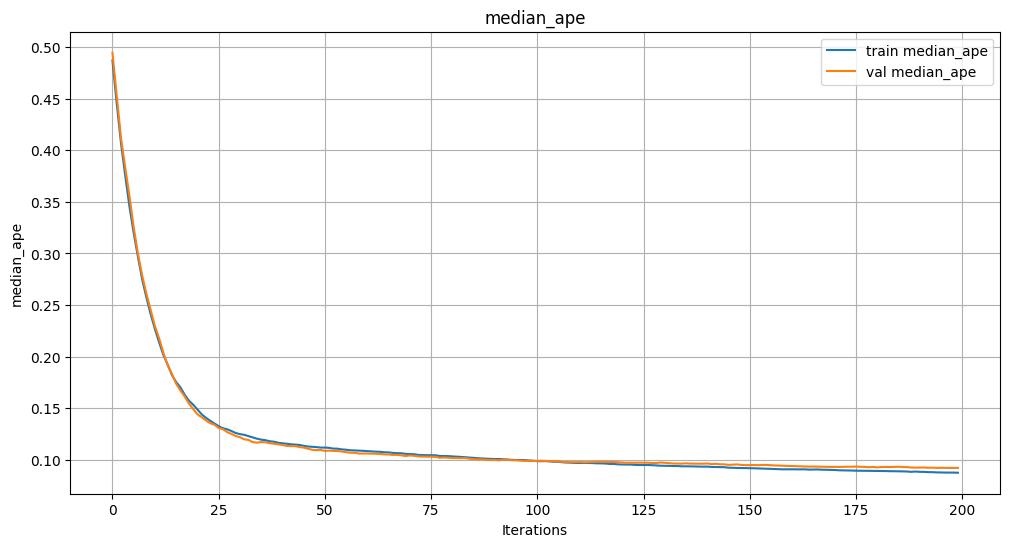

In [ ]:
params = {
    'max_depth': 4,
    'eta': 0.1,
    'objective': 'reg:squarederror',
    'verbosity': 0
}

dtrain = xgb.DMatrix(x_train, label=y_train)
dval = xgb.DMatrix(x_val, label=y_val)

num_boost_round = 200
evals = [(dtrain, 'train'), (dval, 'val')]
evals_result = {}

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=num_boost_round,
    evals=evals,
    feval=median_ape_xg,
    evals_result=evals_result,
    early_stopping_rounds=10,
    verbose_eval=False
)

last_val_metric = evals_result['val']['median_ape'][-1]

plot_metrics(evals_result)

In [ ]:
last_val_metric

0.103078

## Градиентный бустинг из склерна

In [ ]:
x_val.shape

(3074, 105)

In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
    }

    model = GradientBoostingRegressor(**params)
    model.fit(x_train, y_train)

    preds = model.predict(x_val)
    median_ape_value = median_ape(y_val, preds)
    return median_ape_value

In [ ]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

[I 2024-01-19 12:07:54,893] A new study created in memory with name: no-name-bf524198-72e5-4d89-824b-1f6b152ae147
[I 2024-01-19 12:08:01,550] Trial 0 finished with value: 0.08045104003888565 and parameters: {'n_estimators': 100, 'max_depth': 9, 'learning_rate': 0.1, 'subsample': 0.7542810752036478, 'min_samples_split': 8, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.08045104003888565.
[I 2024-01-19 12:08:13,189] Trial 1 finished with value: 0.08503309574243362 and parameters: {'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.1, 'subsample': 0.824212099804387, 'min_samples_split': 10, 'min_samples_leaf': 1}. Best is trial 0 with value: 0.08045104003888565.
[I 2024-01-19 12:08:32,793] Trial 2 finished with value: 0.08810896516892677 and parameters: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.3, 'subsample': 0.8622896049515685, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.08045104003888565.
[I 2024-01-19 12:08:52,429] Trial 3 f

In [ ]:
print('Best trial:', study.best_trial.params)

Best trial: {'n_estimators': 150, 'max_depth': 10, 'learning_rate': 0.05, 'subsample': 0.546818970545078, 'min_samples_split': 5, 'min_samples_leaf': 6}


Итог: 0.07760182749301156

# Нейросети

## Обучение

In [ ]:
def education(model_educ, lr, epochs, batch_size) -> int:

  train_dataset = TensorDataset(torch.tensor(x_train.values).float(), torch.tensor(y_train.values).float())
  val_dataset = TensorDataset(torch.tensor(x_val.values).float(), torch.tensor(y_val.values).float())

  train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_loader = DataLoader(val_dataset, batch_size=batch_size)


  loss_func = nn.MSELoss()
  optimizer = optim.Adam(model_educ.parameters(), lr=lr)

  losses = []
  med_apes = []

  val_losses = []
  val_med_apes = []

  for epoch in range(epochs):
      model_educ.train()
      for inputs, targets in train_loader:

          nn_predictions = model_educ(inputs)
          loss = loss_func(nn_predictions, targets)

          if epoch > 2:
            losses.append(loss.item())
            med_apes.append(median_ape(tensor_to_npa(nn_predictions), tensor_to_npa(targets)))

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

      # model_educ.eval()
      # val_preds = []
      # with torch.no_grad():
      #     for inputs, targets in val_loader:
      #         nn_val_predictions = model_educ(inputs)
      #         val_loss = loss_func(nn_val_predictions, targets)
      #         if epoch > 2:
      #           val_losses.append(val_loss.item())

      #           val_med_apes.append(median_ape(tensor_to_npa(nn_val_predictions), tensor_to_npa(targets)))

      #plot_nn_progress(losses, med_apes, val_losses, val_med_apes, epoch = epoch)

  val_nn_preds = []

  with torch.no_grad():
      for inputs, targets in val_loader:
        nn_val_predictions = model_educ(inputs)
        val_nn_preds.extend(nn_val_predictions)

  return median_ape(y_val, val_nn_preds)

## Полносвязанная

In [ ]:
class CarPriceNN(nn.Module):
    def __init__(self, input_size, hidden_size, dropout_rate=0.3, output_size=1):
        super(CarPriceNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size*2)

        self.fc2 = nn.Linear(hidden_size*2, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

        self.batchnorm = nn.BatchNorm1d(num_features=hidden_size*2)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.batchnorm(x)
        x = self.relu(x)
        x = self.dropout1(x)

        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout2(x)


        x = self.fc3(x)
        return x.squeeze()

## CNN

In [ ]:
import torch.nn as nn

class CarPriceCNN(nn.Module):
    def __init__(self, input_size, hidden_size,
                 output_size=1, num_layers=1, bidirectional=True):
        super(CarPriceCNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=output_size = , kernel_size=1)
        self.conv2 = nn.Conv1d(in_channels=input_size, out_channels=input_size * 2, kernel_size=1)

        self.batchnorm = nn.BatchNorm1d(num_features=self.multiplier *hidden_size)

        self.fc = nn.Linear(hidden_size * self.multiplier, output_size)

    def forward(self, x):
        x, _ = self.lstm(x)

        x = x[:, -1, :].squeeze()
        x = self.batchnorm(x)
        x = self.fc(x)
        return x.squeeze()


In [ ]:
batch_size = 128
hidden_size = 40
lr = 0.001
epochs = 30

## Исслдеование

In [ ]:
train_dataset = TensorDataset(torch.tensor(x_train.values).float(), torch.tensor(y_train.values).float())
val_dataset = TensorDataset(torch.tensor(x_val.values).float(), torch.tensor(y_val.values).float())

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [ ]:
def objective_neural(trial):

    lr = trial.suggest_float("lr", 1e-5, 1e-1, log=True)
    hidden_size = trial.suggest_int("hidden_size", 32, 256)
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.5)
    batch_size = trial.suggest_int("batch_size", 16, 128)
    epochs = 20

    model = CarPriceNN(input_size=x_train.shape[1], hidden_size=hidden_size, dropout_rate=dropout_rate)

    median_ape = education(model, lr, epochs, batch_size)

    return median_ape

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective_neural, n_trials=100)

[I 2024-01-21 13:47:48,254] A new study created in memory with name: no-name-36da8361-1b57-43dc-8677-d4fd43a413f1
[I 2024-01-21 13:48:00,241] Trial 0 finished with value: 0.25879917020481186 and parameters: {'lr': 0.020452553752224514, 'hidden_size': 36, 'dropout_rate': 0.24762955014611948, 'batch_size': 109}. Best is trial 0 with value: 0.25879917020481186.
[I 2024-01-21 13:48:21,769] Trial 1 finished with value: 0.9965846251689366 and parameters: {'lr': 0.00013533964774213695, 'hidden_size': 230, 'dropout_rate': 0.38242385302126436, 'batch_size': 106}. Best is trial 0 with value: 0.25879917020481186.
[I 2024-01-21 13:49:04,129] Trial 2 finished with value: 0.48563874081063263 and parameters: {'lr': 0.00026576808671456857, 'hidden_size': 170, 'dropout_rate': 0.28991551853063335, 'batch_size': 27}. Best is trial 0 with value: 0.25879917020481186.
[I 2024-01-21 13:49:21,600] Trial 3 finished with value: 0.6492126773105016 and parameters: {'lr': 0.0008275391755899221, 'hidden_size': 142,

In [ ]:
print('Best trial:', study.best_trial.params)

Best trial: {'lr': 0.04151968751139869, 'hidden_size': 182, 'dropout_rate': 0.18370300650819077, 'batch_size': 121}


In [ ]:
#{'lr': 0.0415, 'hidden_size': 182, 'dropout_rate': 0.183, 'batch_size': 128}

0.22283

# Дополнение эмбедингами

In [ ]:
train_full_embs = pd.read_csv(way + "train_word_embedings.csv").rename({'Unnamed: 0': 'index'}, axis = 1).set_index('index')
train_full_embs.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
index,,,,,,,,,,,,,,,,,,,,,
198,-0.136773,-0.236483,0.184405,0.326522,0.278908,0.117203,-0.075200,0.397017,0.003556,0.093355,...,0.329008,0.011346,-0.127024,0.110104,-0.011347,0.004729,0.055161,-0.218638,-0.152557,-0.196391
208,-0.001353,-0.290293,-0.006887,0.346501,0.352320,-0.024991,0.034144,0.419570,-0.014774,-0.135728,...,0.298078,-0.050627,0.036470,0.091019,0.049190,0.092731,0.100408,-0.259116,-0.068966,-0.181217
234,0.240349,-0.313524,0.137701,0.350781,0.485873,-0.050425,0.127420,0.496703,0.066005,0.150570,...,0.370183,-0.124120,0.013870,-0.102709,-0.031425,0.109712,0.064723,-0.219945,-0.094727,-0.272479
244,0.025599,-0.278879,-0.037872,0.269796,0.286883,-0.023927,0.137897,0.341825,0.051506,-0.098733,...,0.328323,-0.120835,-0.045487,0.031505,-0.017058,0.068061,0.135129,-0.247531,-0.099456,-0.385271
245,-0.108799,-0.206566,0.128026,0.306782,0.235326,0.068452,-0.126011,0.352885,-0.056698,0.008657,...,0.311782,0.039928,-0.203010,0.101849,0.030943,0.049155,-0.007907,-0.200865,-0.156602,-0.241684


In [ ]:
test_embs = pd.read_csv(way + "test_word_embedings.csv").rename({'Unnamed: 0': 'index'}, axis = 1).set_index('index')
test_embs.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
index,,,,,,,,,,,,,,,,,,,,,
0,0.000835,-0.204455,0.083214,0.290977,0.316612,0.089565,-0.030141,0.375045,-0.014141,0.040395,...,0.291003,-0.022021,-0.062439,-0.012743,0.057703,0.009342,0.025646,-0.219829,-0.073168,-0.291894
1,-0.029547,-0.404774,0.215168,0.170058,0.539107,0.024746,0.025279,0.289502,-0.058079,-0.153708,...,0.351662,0.037015,0.165233,0.077678,-0.063862,0.065041,0.131265,-0.212609,-0.095986,-0.067298
2,0.051490,-0.348438,0.097695,0.312720,0.266076,-0.005203,0.131070,0.326978,0.050851,-0.247518,...,0.313480,-0.218798,-0.038235,0.021309,0.116500,0.016306,0.095284,-0.157061,-0.067626,-0.442151
3,0.112111,-0.318966,0.068437,0.341119,0.353389,0.002861,0.063339,0.397968,0.007571,-0.158017,...,0.348112,-0.083995,0.033925,0.050457,0.096828,0.149982,0.099379,-0.211720,-0.114180,-0.351683
4,-0.066213,-0.128791,0.089555,0.468881,0.331883,-0.010602,0.064044,0.422750,0.043112,-0.012832,...,0.354820,-0.084738,-0.039972,-0.073129,0.060284,0.028653,0.095550,-0.328598,-0.103924,-0.397146


In [ ]:
train_embs = train_full_embs.loc[y_train.index]
val_embs = train_full_embs.loc[y_val.index]

In [ ]:
pca = PCA(n_components = 20)

pca.fit(train_full_embs)

train_full_embs_pca = pca.transform(train_full_embs)
test_embs_pca = pca.transform(test_embs)

train_full_embs_pca = pd.DataFrame(train_full_embs_pca, index=train_full_embs.index)
test_embs_pca = pd.DataFrame(test_embs_pca, index=test_embs.index)

In [ ]:
train_embs_pca = train_full_embs_pca.loc[y_train.index]
train_embs_pca.columns = train_embs_pca.columns.astype(str)

val_embs_pca = train_full_embs_pca.loc[y_val.index]
val_embs_pca.columns = val_embs_pca.columns.astype(str)

x_train_pca = x_train.join(train_embs_pca)
x_val_pca = x_val.join(val_embs_pca)

In [ ]:
x_train_pca.shape

(12293, 125)

In [ ]:
x_val_pca.shape

(3074, 125)

## sklearn

ту немного бредово выглядит, но по дополняем эмбедингами мы уже в разделе "включение эмбедингами", поэтому сверху просто как пример

In [ ]:
def objective100(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300, step=50),
        'max_depth': trial.suggest_int('max_depth', 5, 10),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.04, 0.05, 0.06, 0.07]),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.05),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8),
        'max_features': trial.suggest_float('max_features', 0.05, 1.0, step=0.05)
    }

    model = GradientBoostingRegressor(**params)
    model.fit(x_train, y_train)

    preds = model.predict(x_val)
    median_ape_value = median_ape(y_val, preds)
    return median_ape_value

In [ ]:
study100 = optuna.create_study(direction='minimize')
study100.optimize(objective100, n_trials=100)

[I 2024-01-21 16:56:31,780] A new study created in memory with name: no-name-907fb2d5-ac06-43b3-af84-6d156489d7c6
[I 2024-01-21 16:56:46,069] Trial 0 finished with value: 0.08718229956945028 and parameters: {'n_estimators': 250, 'max_depth': 6, 'learning_rate': 0.06, 'subsample': 0.8, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 0.2}. Best is trial 0 with value: 0.08718229956945028.
[I 2024-01-21 16:57:31,195] Trial 1 finished with value: 0.114510764176589 and parameters: {'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.01, 'subsample': 0.95, 'min_samples_split': 8, 'min_samples_leaf': 7, 'max_features': 0.55}. Best is trial 0 with value: 0.08718229956945028.
[I 2024-01-21 16:57:45,437] Trial 2 finished with value: 0.10481396088453102 and parameters: {'n_estimators': 300, 'max_depth': 6, 'learning_rate': 0.01, 'subsample': 0.6, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.25}. Best is trial 0 with value: 0.08718229956945028.
[I 2024-01-21 

In [ ]:
print('Best trial:', study100.best_trial.params)

Best trial: {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.05, 'subsample': 0.7328312652385061, 'min_samples_split': 6, 'min_samples_leaf': 2}


 0.07561401685268865

## XGBOOST

In [ ]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dval = xgb.DMatrix(x_val, label=y_val)

In [ ]:
def objective_xgb(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    }
    num_boost = trial.suggest_int('n_estimators', 100, 300, step=50)

    model = xgb.train(params, dtrain, num_boost_round=num_boost,
                      evals=[(dval, "validation")], early_stopping_rounds=50,  verbose_eval=False)

    preds = model.predict(dval)
    median_ape_value = median_ape(y_val, preds)
    return median_ape_value

In [ ]:
study_xgb = optuna.create_study(direction="minimize")
study_xgb.optimize(objective_xgb, n_trials=100)

[I 2024-01-21 15:51:12,547] A new study created in memory with name: no-name-e2fad3a0-9f0f-4799-8c9a-47f9cde9ffa2
[I 2024-01-21 15:51:21,669] Trial 0 finished with value: 0.08191468030629229 and parameters: {'max_depth': 8, 'learning_rate': 0.05, 'subsample': 0.8625145195222186, 'colsample_bytree': 0.731647281427565, 'min_child_weight': 2, 'n_estimators': 150}. Best is trial 0 with value: 0.08191468030629229.
[I 2024-01-21 15:51:25,046] Trial 1 finished with value: 0.08074004761296869 and parameters: {'max_depth': 8, 'learning_rate': 0.05, 'subsample': 0.6102811979302204, 'colsample_bytree': 0.8554921166374982, 'min_child_weight': 9, 'n_estimators': 200}. Best is trial 1 with value: 0.08074004761296869.
[I 2024-01-21 15:51:25,966] Trial 2 finished with value: 0.09056180303700427 and parameters: {'max_depth': 5, 'learning_rate': 0.15, 'subsample': 0.9919605852929099, 'colsample_bytree': 0.8411985447617734, 'min_child_weight': 7, 'n_estimators': 100}. Best is trial 1 with value: 0.080740

In [ ]:
print('Best trial:', study_xgb.best_trial.params)

Best trial: {'max_depth': 9, 'learning_rate': 0.05, 'subsample': 0.7564056234922916, 'colsample_bytree': 0.9626410742408514, 'min_child_weight': 2, 'n_estimators': 300}


# Исправление с помощью эмбедингов

## Модель которую правим

Тут градиентный бустинг

In [ ]:
true_params = {'n_estimators': 150,
               'max_depth': 10,
               'learning_rate': 0.05,
               'subsample': 0.546818970545078,
               'min_samples_split': 5,
               'min_samples_leaf': 6}

model1 = GradientBoostingRegressor(**true_params)

model1.fit(x_train, y_train)

train_preds = model1.predict(x_train)
val_preds = model1.predict(x_val)

In [ ]:
y_train_series = pd.Series(y_train, index=y_train.index)
train_preds_series = pd.Series(train_preds, index=y_train.index)

y_val_series = pd.Series(y_val, index=y_val.index)
val_preds_series = pd.Series(val_preds, index=y_val.index)

y_new_train = y_train_series - train_preds_series
y_new_val = y_val_series - val_preds_series

In [ ]:
y_train

379837    1715000.0
281397    2629000.0
276029    1479000.0
409799    1459000.0
125227     757000.0
            ...    
293831    4000000.0
12986     2070000.0
425080    2170000.0
67530     2000000.0
336711     591880.0
Name: actual_price, Length: 12293, dtype: float64

In [ ]:
train_preds

array([1672688.66511863, 2912084.55450304, 1450588.21170668, ...,
       1794292.53214579, 2240004.29119844,  692119.15142462])

In [ ]:
y_new_train

379837     42311.334881
281397   -283084.554503
276029     28411.788293
409799    -46978.393063
125227    -82652.747346
              ...      
293831    361673.067768
12986     156779.142302
425080    375707.467854
67530    -240004.291198
336711   -100239.151425
Length: 12293, dtype: float64

In [ ]:
train_full_embs = pd.read_csv(way + "train_word_embedings.csv").rename({'Unnamed: 0': 'index'}, axis = 1).set_index('index')
train_full_embs.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
index,,,,,,,,,,,,,,,,,,,,,
198,-0.136773,-0.236483,0.184405,0.326522,0.278908,0.117203,-0.075200,0.397017,0.003556,0.093355,...,0.329008,0.011346,-0.127024,0.110104,-0.011347,0.004729,0.055161,-0.218638,-0.152557,-0.196391
208,-0.001353,-0.290293,-0.006887,0.346501,0.352320,-0.024991,0.034144,0.419570,-0.014774,-0.135728,...,0.298078,-0.050627,0.036470,0.091019,0.049190,0.092731,0.100408,-0.259116,-0.068966,-0.181217
234,0.240349,-0.313524,0.137701,0.350781,0.485873,-0.050425,0.127420,0.496703,0.066005,0.150570,...,0.370183,-0.124120,0.013870,-0.102709,-0.031425,0.109712,0.064723,-0.219945,-0.094727,-0.272479
244,0.025599,-0.278879,-0.037872,0.269796,0.286883,-0.023927,0.137897,0.341825,0.051506,-0.098733,...,0.328323,-0.120835,-0.045487,0.031505,-0.017058,0.068061,0.135129,-0.247531,-0.099456,-0.385271
245,-0.108799,-0.206566,0.128026,0.306782,0.235326,0.068452,-0.126011,0.352885,-0.056698,0.008657,...,0.311782,0.039928,-0.203010,0.101849,0.030943,0.049155,-0.007907,-0.200865,-0.156602,-0.241684


In [ ]:
test_embs = pd.read_csv(way + "test_word_embedings.csv").rename({'Unnamed: 0': 'index'}, axis = 1).set_index('index')
test_embs.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
index,,,,,,,,,,,,,,,,,,,,,
0,0.000835,-0.204455,0.083214,0.290977,0.316612,0.089565,-0.030141,0.375045,-0.014141,0.040395,...,0.291003,-0.022021,-0.062439,-0.012743,0.057703,0.009342,0.025646,-0.219829,-0.073168,-0.291894
1,-0.029547,-0.404774,0.215168,0.170058,0.539107,0.024746,0.025279,0.289502,-0.058079,-0.153708,...,0.351662,0.037015,0.165233,0.077678,-0.063862,0.065041,0.131265,-0.212609,-0.095986,-0.067298
2,0.051490,-0.348438,0.097695,0.312720,0.266076,-0.005203,0.131070,0.326978,0.050851,-0.247518,...,0.313480,-0.218798,-0.038235,0.021309,0.116500,0.016306,0.095284,-0.157061,-0.067626,-0.442151
3,0.112111,-0.318966,0.068437,0.341119,0.353389,0.002861,0.063339,0.397968,0.007571,-0.158017,...,0.348112,-0.083995,0.033925,0.050457,0.096828,0.149982,0.099379,-0.211720,-0.114180,-0.351683
4,-0.066213,-0.128791,0.089555,0.468881,0.331883,-0.010602,0.064044,0.422750,0.043112,-0.012832,...,0.354820,-0.084738,-0.039972,-0.073129,0.060284,0.028653,0.095550,-0.328598,-0.103924,-0.397146


In [ ]:
train_embs = train_full_embs.loc[y_train.index]
val_embs = train_full_embs.loc[y_val.index]

In [ ]:
train_embs.shape

(12293, 200)

In [ ]:
val_embs.shape

(3074, 200)

## Само исправление

In [ ]:
base2 = y_new_train.mean()
median_ape(y_new_val, base2)

1.000963977683686

In [ ]:
model10 = LinearRegression()

model10.fit(train_embs, y_new_train)
preds = model10.predict(val_embs)
median_ape(y_new_val, preds)

0.9784030396319638

### Градиентный бустинг снова

In [ ]:
def objective11(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 300, step=50),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
    }

    model = GradientBoostingRegressor(**params)
    model.fit(train_embs, y_new_train)

    preds = model.predict(val_embs)
    median_ape_value = median_ape(y_new_val, preds)
    return median_ape_value

In [ ]:
study11 = optuna.create_study(direction='minimize')
study11.optimize(objective11, n_trials=100)

[I 2024-01-19 18:23:55,628] A new study created in memory with name: no-name-28c6f0db-cfe4-440d-8c4c-2863fb4eab23
[I 2024-01-19 18:25:41,446] Trial 0 finished with value: 0.9951942313984827 and parameters: {'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.01, 'subsample': 0.5138253071960717, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.9951942313984827.
[I 2024-01-19 18:30:12,447] Trial 1 finished with value: 1.0324945887436856 and parameters: {'n_estimators': 200, 'max_depth': 7, 'learning_rate': 0.25, 'subsample': 0.5894924564669585, 'min_samples_split': 10, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9951942313984827.
[I 2024-01-19 18:33:50,683] Trial 2 finished with value: 0.9813619772878333 and parameters: {'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.15, 'subsample': 0.8628136344634403, 'min_samples_split': 9, 'min_samples_leaf': 10}. Best is trial 2 with value: 0.9813619772878333.
[I 2024-01-19 18:35:51,151] Trial 3 fi

KeyboardInterrupt: 

Получилась какая-то полная чушь

### Нейросеть

In [ ]:
class SimpleNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size*3)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size*3, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x.squeeze()

In [ ]:
batch_size = 128
hidden_size = 40
lr = 0.01
epochs = 20

In [ ]:
train_dataset = TensorDataset(torch.tensor(train_embs.values).float(), torch.tensor(y_new_train.values).float())
val_dataset = TensorDataset(torch.tensor(val_embs.values).float(), torch.tensor(y_new_val.values).float())

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

In [ ]:
def tensor_to_npa(tensor_x):
  return tensor_x.detach().numpy()

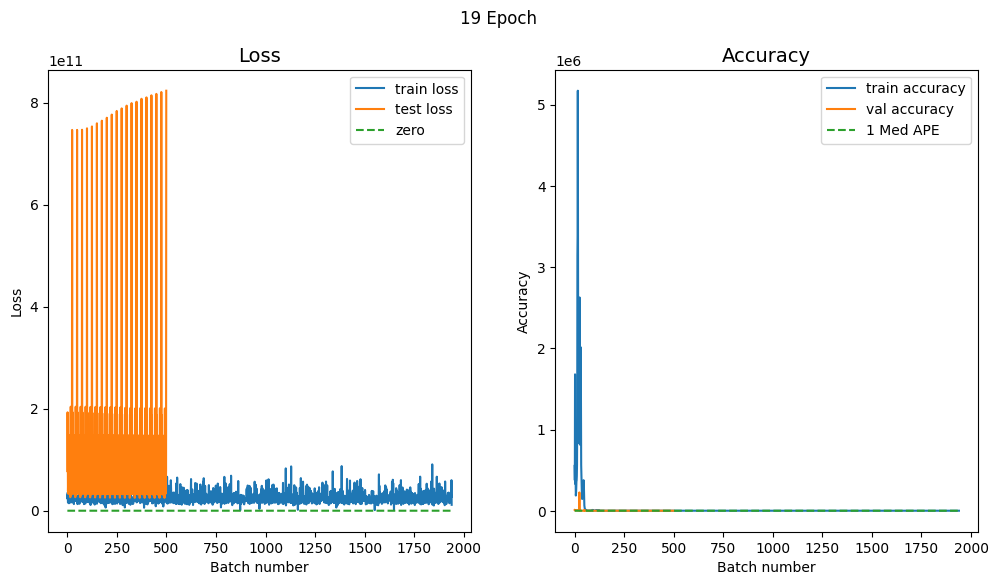

In [ ]:
model12 = SimpleNN(input_size=train_embs.shape[1], hidden_size=hidden_size)
loss_func = nn.MSELoss()
optimizer = optim.Adam(model12.parameters(), lr=lr)

losses = []
med_apes = []

val_losses = []
val_med_apes = []

for epoch in range(epochs):
    model12.train()
    for inputs, targets in train_loader:

        nn_predictions = model12(inputs)
        loss = loss_func(nn_predictions, targets)

        med_apes.append(median_ape(tensor_to_npa(nn_predictions), tensor_to_npa(targets)))
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model12.eval()
    val_preds = []
    with torch.no_grad():
        for inputs, targets in val_loader:
            nn_val_predictions = model12(inputs)
            val_loss = loss_func(nn_val_predictions, targets)

            val_losses.append(val_loss.item())

            val_med_apes.append(median_ape(tensor_to_npa(nn_val_predictions), tensor_to_npa(targets)))

    plot_nn_progress(losses, med_apes, val_losses, val_med_apes, epoch = epoch)

In [ ]:
val_nn_preds = []

with torch.no_grad():
    for inputs, targets in val_loader:
      nn_val_predictions = model12(inputs)
      val_nn_preds.extend(nn_val_predictions)

median_ape(y_new_val, val_nn_preds)

0.99151239953124

# Результаты

На текущий момент не используются:

*   изображения
*   equipment
*   sale_end_date


град буст, значение: 0.07760182749301156

параметры: {'n_estimators': 150, 'max_depth': 10, 'learning_rate': 0.05, 'subsample': 0.546818970545078, 'min_samples_split': 5, 'min_samples_leaf': 6}

In [ ]:
# true_params = {'n_estimators': 150,
#                'max_depth': 10,
#                'learning_rate': 0.05,
#                'subsample': 0.546818970545078,
#                'min_samples_split': 5,
#                'min_samples_leaf': 6}

true_params = {'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.05, 'subsample': 0.75, 'min_samples_split': 6, 'min_samples_leaf': 2}

end_model1 = GradientBoostingRegressor(**true_params)
end_model1.fit(x_full_train, y_full_train)

preds = end_model1.predict(base_test)

In [ ]:
preds

array([ 532288.23016796, 1343998.37324404, 2985922.00287576, ...,
       2194354.97617581, 8836649.39429512, 2347084.56543011])

In [ ]:
pd.Series(preds).to_csv('solution.csv', header=False, index=False)